In [1]:
import pandas as pd
from termcolor import colored
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 20000)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import accumulate

In [3]:
df=pd.read_csv('asset/model_use/fresh_data.csv')

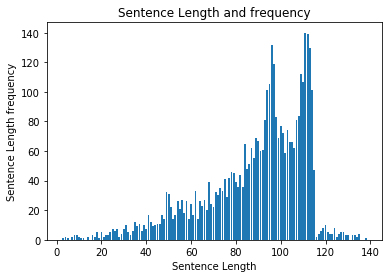

In [4]:
df['length'] = df['tidy_text'].astype(str).apply(lambda x: len(x))
len_df = df.groupby('length').count()
sent_length = len_df.index.tolist()
sent_freq = len_df['tidy_text'].tolist()
plt.bar(sent_length, sent_freq)
plt.title("Sentence Length and frequency")
plt.xlabel("Sentence Length")
plt.ylabel("Sentence Length frequency")
# plt.savefig("asset/model_use/Sentence Length and frequency.png")
plt.show()

In [5]:
# quantile 
quantile = 0.91
#print(list(sent_pentage_list))
sent_pentage_list = [(count/sum(sent_freq)) for count in accumulate(sent_freq)]
for length, per in zip(sent_length, sent_pentage_list):
    if round(per, 2) == quantile:
        index = length
        break
print("Sentence Lenght(Quantile %a):%d." % (quantile, index))

Sentence Lenght(Quantile 0.91):112.


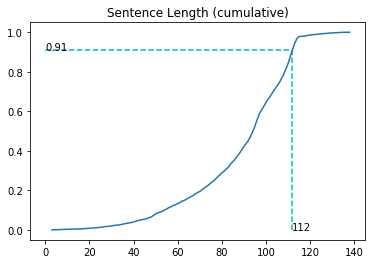

In [6]:
plt.plot(sent_length, sent_pentage_list)
plt.hlines(quantile, 0, index, colors="c", linestyles="dashed")
plt.vlines(index, 0, quantile, colors="c", linestyles="dashed")
plt.text(0, quantile, str(quantile))
plt.text(index, 0, str(index))
plt.title("Sentence Length (cumulative)")
# plt.savefig("asset/model_use/Sentence Length().png")
plt.show()

### Model Building

In [7]:
data=pd.read_csv('asset/model_use/fresh_data.csv')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['tone'], test_size = 0.30, random_state = 100)
train_data = pd.DataFrame({'Tweet': X_train,'Sentiment': y_train})
test_data = pd.DataFrame({'Tweet': X_test,'Sentiment': y_test})

In [9]:
train_data['Sentiment'].value_counts()

neutral     1130
positive     904
negative     766
Name: Sentiment, dtype: int64

In [10]:
test_data['Sentiment'].value_counts()

neutral     505
positive    383
negative    313
Name: Sentiment, dtype: int64

In [11]:
# test_data.to_csv('asset/model_use/test.csv', index = False)
# train_data.to_csv('asset/model_use/train.csv', index = False)

In [12]:
import re
import nltk
import numpy as np
import pandas as pd
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Think\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Think\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from bs4 import BeautifulSoup
import re
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
   
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [14]:
def clean_tweet(data):
    data_list = list(data['Tweet'])
    clean_list=[]
    for t in data_list:
        clean_list.append(tweet_cleaner(t))
    data['tidy_tweet']=clean_list
    return data

In [15]:
train_data = clean_tweet(train_data)

In [16]:
test_data = clean_tweet(test_data)

In [17]:
import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from termcolor import colored

Using TensorFlow backend.


In [18]:
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['tidy_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['tidy_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['tidy_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

In [19]:
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 27, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 27, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 651,011
Trainable params: 651,011
Non-trainable params: 0
_________________________________________________________________


In [20]:
print(colored("Training the LSTM model", "green"))
history = model.fit(train_tweets, pd.get_dummies(train_data['Sentiment']).values, epochs = 10, batch_size = 128, validation_split = 0.2)

Training the LSTM model


C:\Users\Think\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2240 samples, validate on 560 samples
Epoch 1/10
2240/2240 [==============================] - 5s 2ms/step - loss: 1.0689 - accuracy: 0.4143 - val_loss: 1.0633 - val_accuracy: 0.4179
Epoch 2/10
2240/2240 [==============================] - 5s 2ms/step - loss: 1.0238 - accuracy: 0.4746 - val_loss: 1.0352 - val_accuracy: 0.4625
Epoch 3/10
2240/2240 [==============================] - 4s 2ms/step - loss: 0.9363 - accuracy: 0.5621 - val_loss: 0.9597 - val_accuracy: 0.5196
Epoch 4/10
2240/2240 [==============================] - 5s 2ms/step - loss: 0.7484 - accuracy: 0.6719 - val_loss: 0.8785 - val_accuracy: 0.6196
Epoch 5/10
2240/2240 [==============================] - 5s 2ms/step - loss: 0.5435 - accuracy: 0.7911 - val_loss: 0.8566 - val_accuracy: 0.6571
Epoch 6/10
2240/2240 [==============================] - 5s 2ms/step - loss: 0.4758 - accuracy: 0.8214 - val_loss: 0.8917 - val_accuracy: 0.6661
Epoch 7/10
2240/2240 [==============================] - 4s 2ms/step - loss: 0.3565 - accu

In [21]:
print(colored("Testing the LSTM model", "green"))
score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['Sentiment']).values, batch_size = 128)
# print("Score: {}".format(score))
print("Test accuracy: {}".format(accuracy))

Testing the LSTM model
1201/1201 [==============================] - 1s 608us/step
Test accuracy: 0.674437940120697


In [22]:
model.save('asset/model_use/lstm_model.h5')

###Predicting

In [184]:
new_data=pd.read_csv('asset/record/origin_data.csv')[4001:]

In [185]:
new_data['Tweet']=new_data['text']

In [186]:
new_data=clean_tweet(new_data)

In [187]:
new_data.set_index('tweet_id', inplace=True)

In [188]:
new_tweets = tokenizer.texts_to_sequences(new_data['Tweet'].astype(str).values)
new_tweets = pad_sequences(new_tweets, maxlen = max_len)

In [189]:
prediction=model.predict(new_tweets, verbose=0)

In [190]:
tone=[]
for pre in prediction:
    dic={'negative':pre[0],'neutral':pre[1],'positive':pre[2]}
    tone.append(max(dic, key=dic.get))

In [191]:
new_data['tone']=tone

In [192]:
new_data.drop(['Tweet'], axis=1, inplace=True)

In [193]:
new_data.to_csv('asset/record/new_data.csv',quoting=csv.QUOTE_NONE)

In [194]:
### Combine all the data

In [207]:
df1=pd.read_csv('asset/model_use/fresh_data.csv', index_col='tweet_id')
df2=pd.read_csv('asset/record/new_data.csv',index_col='tweet_id')

In [208]:
df2.rename(columns={'tidy_tweet':'tidy_text'}, inplace=True)

In [209]:
import ast
df1[['latitude','longitude']]=pd.DataFrame(df1.coordinates.apply(lambda s: list(ast.literal_eval(s))).values.tolist(),
                                           index=df1.index, columns=['latitude','longitude'])

In [210]:
df1.drop(['polarity','subjectivity'], axis=1, inplace=True)

In [211]:
cols = list(df1.columns.values)

In [212]:
cols=['date',
 'text',
 'favorite_count',
 'retweet_count',
 'at_mentions',
 'at_mentions_id',
 'hashtags',
 'user_id',
 'user_name',
 'user_profile',
 'in_reply_to_tweet_id',
 'country',
 'place',
 'lang',
 'coordinates',
 'latitude',
 'longitude',
 'tidy_text',
 'tone']

In [213]:
df1=df1[cols]

In [222]:
df=pd.concat([df1, df2])

In [225]:
df.to_csv('asset/record/all_data.csv')